In [63]:
# Read in the dataset
import pandas as pd

data = pd.read_csv("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE213nnn/GSE213001/suppl/GSE213001_Entrez-IDs-Lung-IPF-GRCh38-p12-logRPKMs-normalised.csv.gz")
#Formatting data
data = data.T
data.columns = data.iloc[0]
data = data[1:]

In [51]:
#Visualise dataset
data.head()

Unnamed: 0,ENSG00000279457,ENSG00000187634,ENSG00000188976,ENSG00000187961,ENSG00000187583,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000131591,ENSG00000162571,...,ENSG00000276256,ENSG00000278384,ENSG00000273748,ENSG00000271254,ENSG00000276345,ENSG00000277856,ENSG00000275063,ENSG00000277836,ENSG00000278817,ENSG00000277196
ALF001,0.425153,2.51243,2.854027,0.715562,-0.798884,3.406323,3.212063,3.35338,-0.017405,-1.697047,...,-2.211442,-3.29212,2.455685,1.308309,-2.360475,6.053167,9.100593,4.438835,-0.749863,0.960298
ALF004C,1.251825,2.896548,3.326001,2.462509,0.490337,3.673231,3.921884,4.146812,1.337476,-1.615703,...,-1.075146,-1.925291,2.931091,-0.802052,2.237658,6.268709,6.142145,3.123983,0.33632,3.277525
ALF004D,1.922723,2.937697,3.531268,2.501007,0.969083,4.016567,4.104159,4.000644,1.421227,0.425761,...,-1.17054,-1.762715,2.578291,0.035227,2.391867,7.505255,8.178596,4.267273,0.013557,3.328584
ALF007A,1.246318,2.509907,3.31191,2.149018,-0.480106,3.626264,4.802501,3.226986,1.345913,-0.804579,...,-0.699396,-2.342168,2.824359,0.752791,-2.360475,5.285377,8.283409,3.063957,0.073352,0.93475
ALF007B,0.836553,1.74153,3.059992,1.311676,-0.627639,3.481195,3.80429,2.8794,0.627536,-1.163588,...,-1.097773,-1.910445,2.74551,1.111594,-1.766143,7.293695,10.360277,4.454531,-0.048991,1.053662


In [64]:
# Convert gene ids to gene names
import mygene

mg = mygene.MyGeneInfo()

clean_ids = data.columns.str.replace(r"\.\d+$","",regex=True)

res = mg.querymany(
    clean_ids.tolist(),
    scopes="ensembl.gene",
    fields="symbol",
    species="human"
)

mapping = {
    entry["query"]: entry.get("symbol", entry["query"])
    for entry in res
}

data.columns = [mapping.get(id_, id_) for id_ in clean_ids]

print(data.head())

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000175711', 2)]
16 input query terms found no hit:	['ENSG00000112096', 'ENSG00000168078', 'ENSG00000213865', 'ENSG00000243444', 'ENSG00000130723', 'ENS


           WASH9P    SAMD11     NOC2L    KLHL17   PLEKHN1      HES4     ISG15  \
ALF001   0.425153   2.51243  2.854027  0.715562 -0.798884  3.406323  3.212063   
ALF004C  1.251825  2.896548  3.326001  2.462509  0.490337  3.673231  3.921884   
ALF004D  1.922723  2.937697  3.531268  2.501007  0.969083  4.016567  4.104159   
ALF007A  1.246318  2.509907   3.31191  2.149018 -0.480106  3.626264  4.802501   
ALF007B  0.836553   1.74153  3.059992  1.311676 -0.627639  3.481195   3.80429   

             AGRN  C1orf159    TTLL10  ... ENSG00000276256 ENSG00000278384  \
ALF001    3.35338 -0.017405 -1.697047  ...       -2.211442        -3.29212   
ALF004C  4.146812  1.337476 -1.615703  ...       -1.075146       -1.925291   
ALF004D  4.000644  1.421227  0.425761  ...        -1.17054       -1.762715   
ALF007A  3.226986  1.345913 -0.804579  ...       -0.699396       -2.342168   
ALF007B    2.8794  0.627536 -1.163588  ...       -1.097773       -1.910445   

        ENSG00000273748 LOC124905564 ENSG000

In [65]:
#filter the non-identified columns 
filtered_data = data.drop(columns=data.filter(like='ENSG').columns)

In [66]:
#filter out the rows that end with E or F and remove them as they are unclassified samples from the original data
filtered_data = filtered_data[~filtered_data.index.str.endswith(("E", "F"))]


In [67]:
location_map = {
    "A": "Left Apex",
    "B": "Left Base",
    "C": "Right Apex",
    "D": "Right Base"
}
ALF001_mapping = {
    "ALF001": "Left Base"
}

filtered_data["Location"] = (
    filtered_data.index.to_series()     
    .map(ALF001_mapping)                     
    .fillna(filtered_data.index.to_series()
        .str[-1].map(location_map)
    )
)
filtered_data

,WASH9P,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,LOC124905564,LOC102723407,Location
ALF001,0.425153,2.51243,2.854027,0.715562,-0.798884,3.406323,3.212063,3.35338,-0.017405,-1.697047,...,13.353025,12.146672,12.195432,13.282175,11.694904,6.597997,12.284754,1.308309,9.100593,Left Base
ALF004C,1.251825,2.896548,3.326001,2.462509,0.490337,3.673231,3.921884,4.146812,1.337476,-1.615703,...,13.770486,12.567404,12.047708,13.450474,11.283006,5.809402,12.41761,-0.802052,6.142145,Right Apex
ALF004D,1.922723,2.937697,3.531268,2.501007,0.969083,4.016567,4.104159,4.000644,1.421227,0.425761,...,13.80112,12.257564,11.586399,13.392677,11.038485,5.794909,12.413593,0.035227,8.178596,Right Base
ALF007A,1.246318,2.509907,3.31191,2.149018,-0.480106,3.626264,4.802501,3.226986,1.345913,-0.804579,...,12.939696,11.764527,11.494059,12.68195,10.893037,5.090001,11.961818,0.752791,8.283409,Left Apex
ALF007B,0.836553,1.74153,3.059992,1.311676,-0.627639,3.481195,3.80429,2.8794,0.627536,-1.163588,...,12.898247,11.811071,11.599336,12.728233,11.412413,5.265747,11.950885,1.111594,10.360277,Left Base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALF049B,1.04795,0.859944,3.19916,1.600734,-1.924095,2.882285,5.398893,4.150006,0.579633,-0.829335,...,12.374373,11.431679,11.108365,12.239561,11.35321,4.709066,11.184222,0.568636,4.968253,Left Base
ALF050A,1.504617,-0.496098,3.025537,2.236028,-0.692942,3.760855,5.125451,3.834124,0.917207,-2.055903,...,13.077694,12.383921,12.412743,13.317289,12.227909,7.230105,12.418244,0.992021,1.32811,Left Apex
ALF050B,1.476723,-1.534927,3.195727,1.96914,-0.543239,3.182776,4.924864,3.713029,0.883612,-2.074571,...,12.814415,11.796742,11.757809,12.879916,11.891618,6.156113,11.934138,1.146763,1.96262,Left Base
ALF050C,1.351157,-1.453174,3.056888,2.232133,-1.210655,2.933959,5.331205,3.518521,1.004519,-1.618582,...,13.508189,12.901829,12.750531,13.847675,12.563557,7.852521,12.788341,0.484489,0.522198,Right Apex


In [68]:
IPF_samples = [1,8,19,40,47,41,28,29,32,37,45,38,15,35,18,16,27,23,43,39]
NDC_samples = [13,30,20,9,26,24,25,17,50,49,44,12,34,10]
ILD_samples = [4,42,36,14,22,31,21,7,33,46,11,48]

condition_map = {}
condition_map = {str(s).zfill(3): "IPF" for s in IPF_samples}
condition_map.update({str(s).zfill(3): "NDC" for s in NDC_samples})
condition_map.update({str(s).zfill(3): "ILD" for s in ILD_samples})

filtered_data["SampleNumber"] = (
    filtered_data.index.to_series()
    .str.replace(r"[A-Z]$", "", regex=True)  # remove A/B/C/D
    .str.replace("ALF", "", regex=False)     # remove prefix
    .astype(int)
    .astype(str)
    .str.zfill(3)
)

filtered_data["Condition"] = filtered_data["SampleNumber"].map(condition_map)
filtered_data = filtered_data.drop(columns="SampleNumber")
filtered_data



,WASH9P,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,LOC124905564,LOC102723407,Location,Condition
ALF001,0.425153,2.51243,2.854027,0.715562,-0.798884,3.406323,3.212063,3.35338,-0.017405,-1.697047,...,12.146672,12.195432,13.282175,11.694904,6.597997,12.284754,1.308309,9.100593,Left Base,IPF
ALF004C,1.251825,2.896548,3.326001,2.462509,0.490337,3.673231,3.921884,4.146812,1.337476,-1.615703,...,12.567404,12.047708,13.450474,11.283006,5.809402,12.41761,-0.802052,6.142145,Right Apex,ILD
ALF004D,1.922723,2.937697,3.531268,2.501007,0.969083,4.016567,4.104159,4.000644,1.421227,0.425761,...,12.257564,11.586399,13.392677,11.038485,5.794909,12.413593,0.035227,8.178596,Right Base,ILD
ALF007A,1.246318,2.509907,3.31191,2.149018,-0.480106,3.626264,4.802501,3.226986,1.345913,-0.804579,...,11.764527,11.494059,12.68195,10.893037,5.090001,11.961818,0.752791,8.283409,Left Apex,ILD
ALF007B,0.836553,1.74153,3.059992,1.311676,-0.627639,3.481195,3.80429,2.8794,0.627536,-1.163588,...,11.811071,11.599336,12.728233,11.412413,5.265747,11.950885,1.111594,10.360277,Left Base,ILD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALF049B,1.04795,0.859944,3.19916,1.600734,-1.924095,2.882285,5.398893,4.150006,0.579633,-0.829335,...,11.431679,11.108365,12.239561,11.35321,4.709066,11.184222,0.568636,4.968253,Left Base,NDC
ALF050A,1.504617,-0.496098,3.025537,2.236028,-0.692942,3.760855,5.125451,3.834124,0.917207,-2.055903,...,12.383921,12.412743,13.317289,12.227909,7.230105,12.418244,0.992021,1.32811,Left Apex,NDC
ALF050B,1.476723,-1.534927,3.195727,1.96914,-0.543239,3.182776,4.924864,3.713029,0.883612,-2.074571,...,11.796742,11.757809,12.879916,11.891618,6.156113,11.934138,1.146763,1.96262,Left Base,NDC
ALF050C,1.351157,-1.453174,3.056888,2.232133,-1.210655,2.933959,5.331205,3.518521,1.004519,-1.618582,...,12.901829,12.750531,13.847675,12.563557,7.852521,12.788341,0.484489,0.522198,Right Apex,NDC


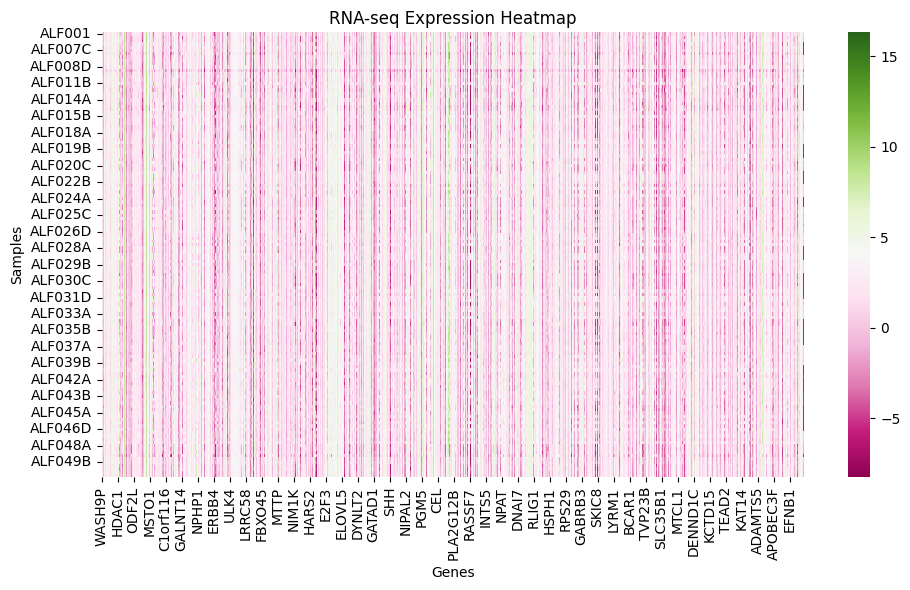

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# keep only numeric expression values
heatmap_data = filtered_data.drop(
    columns=["Condition"],
    errors="ignore"
)
heatmap_data = heatmap_data.apply(pd.to_numeric, errors="coerce")
heatmap_data = heatmap_data.dropna(axis=0, how="all")
heatmap_data = heatmap_data.dropna(axis=1, how="all")


# optional: select subset of genes
#heatmap_data = heatmap_data.iloc[:, :20]  # first 20 genes

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    cmap="PiYG",
    cbar=True
)

plt.xlabel("Genes")
plt.ylabel("Samples")
plt.title("RNA-seq Expression Heatmap")
plt.tight_layout()
plt.show()


In [73]:
filtered_data

,WASH9P,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,LOC124905564,LOC102723407,Location,Condition
ALF001,0.425153,2.51243,2.854027,0.715562,-0.798884,3.406323,3.212063,3.35338,-0.017405,-1.697047,...,12.146672,12.195432,13.282175,11.694904,6.597997,12.284754,1.308309,9.100593,Left Base,IPF
ALF004C,1.251825,2.896548,3.326001,2.462509,0.490337,3.673231,3.921884,4.146812,1.337476,-1.615703,...,12.567404,12.047708,13.450474,11.283006,5.809402,12.41761,-0.802052,6.142145,Right Apex,ILD
ALF004D,1.922723,2.937697,3.531268,2.501007,0.969083,4.016567,4.104159,4.000644,1.421227,0.425761,...,12.257564,11.586399,13.392677,11.038485,5.794909,12.413593,0.035227,8.178596,Right Base,ILD
ALF007A,1.246318,2.509907,3.31191,2.149018,-0.480106,3.626264,4.802501,3.226986,1.345913,-0.804579,...,11.764527,11.494059,12.68195,10.893037,5.090001,11.961818,0.752791,8.283409,Left Apex,ILD
ALF007B,0.836553,1.74153,3.059992,1.311676,-0.627639,3.481195,3.80429,2.8794,0.627536,-1.163588,...,11.811071,11.599336,12.728233,11.412413,5.265747,11.950885,1.111594,10.360277,Left Base,ILD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALF049B,1.04795,0.859944,3.19916,1.600734,-1.924095,2.882285,5.398893,4.150006,0.579633,-0.829335,...,11.431679,11.108365,12.239561,11.35321,4.709066,11.184222,0.568636,4.968253,Left Base,NDC
ALF050A,1.504617,-0.496098,3.025537,2.236028,-0.692942,3.760855,5.125451,3.834124,0.917207,-2.055903,...,12.383921,12.412743,13.317289,12.227909,7.230105,12.418244,0.992021,1.32811,Left Apex,NDC
ALF050B,1.476723,-1.534927,3.195727,1.96914,-0.543239,3.182776,4.924864,3.713029,0.883612,-2.074571,...,11.796742,11.757809,12.879916,11.891618,6.156113,11.934138,1.146763,1.96262,Left Base,NDC
ALF050C,1.351157,-1.453174,3.056888,2.232133,-1.210655,2.933959,5.331205,3.518521,1.004519,-1.618582,...,12.901829,12.750531,13.847675,12.563557,7.852521,12.788341,0.484489,0.522198,Right Apex,NDC


In [137]:
#create new datafraem with just IPF and NDC
filtered_data_ipf_ctrl = filtered_data[filtered_data['Condition'].isin(['IPF', 'NDC'])].copy()
filtered_data_ipf_ctrl.head(10)





,WASH9P,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,LOC124905564,LOC102723407,Location,Condition
ALF001,0.425153,2.51243,2.854027,0.715562,-0.798884,3.406323,3.212063,3.35338,-0.017405,-1.697047,...,12.146672,12.195432,13.282175,11.694904,6.597997,12.284754,1.308309,9.100593,Left Base,IPF
ALF008A,0.506582,3.122498,3.274516,2.021997,1.107451,3.077058,4.341413,3.497495,0.942714,-3.276052,...,11.757592,11.593656,12.655937,10.942963,5.432288,11.685694,0.875971,8.265851,Left Apex,IPF
ALF008B,0.517803,3.681952,2.969209,1.926322,-0.151754,3.954289,4.825383,3.73346,0.744685,-2.369927,...,11.790319,11.640294,12.644314,10.162683,5.937651,11.68797,0.904698,5.549283,Left Base,IPF
ALF008C,0.522179,3.706251,3.169481,1.560275,0.564445,3.516473,5.040354,3.686234,1.024235,-3.083491,...,11.662769,11.69277,12.729395,10.347433,5.697362,11.598813,0.898786,4.385433,Right Apex,IPF
ALF008D,0.66065,3.301887,3.309272,1.791007,0.638534,4.039028,4.66566,4.126266,1.002662,2.508594,...,11.906518,11.809825,12.927826,10.567794,5.833538,11.797534,0.731851,6.046208,Right Base,IPF
ALF009B,0.681273,0.263716,2.916954,1.375671,-0.854851,4.638277,3.455802,1.394545,1.138525,-2.927168,...,15.477671,15.065285,16.255459,15.047055,9.204283,15.456502,-1.276477,0.070885,Left Base,NDC
ALF009C,0.406864,0.354824,3.128468,1.06406,-1.195197,3.272347,4.111703,2.856971,0.781982,-1.67216,...,12.916043,12.977416,13.971144,12.40994,6.673012,13.095727,0.311638,2.169337,Right Apex,NDC
ALF010A,0.05114,-0.294543,2.936795,1.483311,-2.361205,3.195893,4.878325,2.987546,0.730442,-1.529387,...,13.529678,13.155484,14.267749,13.157584,8.135771,13.649454,0.430227,3.586655,Left Apex,NDC
ALF012A,0.793388,0.539316,3.016837,1.402299,-1.107074,2.614188,5.841249,3.212517,0.354226,-3.845899,...,13.057,12.945377,14.136639,12.78539,7.865739,13.125603,0.454705,4.243831,Left Apex,NDC
ALF012B,1.020982,0.539169,3.522152,2.160827,0.347165,2.457509,6.960978,2.125762,1.372247,-2.899311,...,13.129309,13.082835,14.492643,12.546163,8.377413,13.358741,-0.455511,2.557382,Left Base,NDC


In [80]:
#Turning the IPF and NDC into groups: 

g1 = "IPF" 

g2 = "NDC"   

#Assigning the groups to the column where they come from: 

filtered_data["Condition"].unique() 

array(['IPF', 'ILD', 'NDC'], dtype=object)

In [86]:
# Creates another dataframe that contains only genes for condition and location. drops other columns
import pandas as pd
import numpy as np

# Copy dataframe
data_copy = filtered_data.copy()

# Metadata
meta = data_copy[['Condition', 'Location']]

# Expression matrix (genes only)
expr = data_copy.drop(columns=['Condition', 'Location'])


In [89]:

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def differential_expression(expr, meta, group1, group2):
    # Select samples
    idx1 = meta['Condition'] == group1
    idx2 = meta['Condition'] == group2

    results = []

    for gene in expr.columns:
        g1 = expr.loc[idx1, gene]
        g2 = expr.loc[idx2, gene]

        # Log2 fold change
        log2fc = np.log2(g1.mean() + 1e-6) - np.log2(g2.mean() + 1e-6)

        # Statistical test
        stat, pval = ttest_ind(g1, g2, equal_var=False, nan_policy='omit')

        results.append([gene, log2fc, pval])

    res = pd.DataFrame(results, columns=['gene', 'log2FoldChange', 'pvalue'])

    # FDR correction
    res['padj'] = multipletests(res['pvalue'], method='fdr_bh')[1]

    return res


In [110]:
# Checking what kind of data conditions was set in. It is counts data
meta['Condition'].value_counts()

# turning into numeric 
expr = expr.apply(pd.to_numeric, errors='coerce')

# checking if it has changed to numeric 
expr.dtypes.value_counts()

# In summary: This code checks sample group sizes and ensures that all gene expression values are numeric, which is required for statistical testing and fold-change calculation in RNA-seq analysis.

float64    15022
Name: count, dtype: int64

In [111]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np

def differential_expression(expr, meta, group1, group2, min_n=2):
    idx1 = meta['Condition'] == group1
    idx2 = meta['Condition'] == group2

    results = []

    for gene in expr.columns:
        g1 = expr.loc[idx1, gene].dropna()
        g2 = expr.loc[idx2, gene].dropna()

        # Skip if too few samples
        if len(g1) < min_n or len(g2) < min_n:
            continue

        # Skip genes with no variance
        if g1.var() == 0 and g2.var() == 0:
            continue

        # Mean expression must be positive
        if g1.mean() <= 0 or g2.mean() <= 0:
            continue

        log2fc = np.log2(g1.mean()) - np.log2(g2.mean())

        stat, pval = ttest_ind(g1, g2, equal_var=False)

        results.append([gene, log2fc, pval])

    res = pd.DataFrame(results, columns=['gene', 'log2FoldChange', 'pvalue'])

    if res.empty:
        return res

    res['padj'] = multipletests(res['pvalue'], method='fdr_bh')[1]
    return res


In [107]:
ipf_vs_ctrl = differential_expression(expr, meta, 'IPF', 'NDC')
ild_vs_ctrl = differential_expression(expr, meta, 'ILD', 'NDC')
ipf_vs_ild  = differential_expression(expr, meta, 'IPF', 'ILD')


In [128]:
# this is for control (NDC) vs IPF - upregulated genes 
sig_ipf_ctrl = ipf_vs_ctrl[
    (ipf_vs_ctrl['padj'] < 0.05) &
    (abs(ipf_vs_ctrl['log2FoldChange']) > 2)
]

sig_ipf_ctrl.sort_values('padj').head(20)


,gene,log2FoldChange,pvalue,padj
1630,FHL2,2.014081,8.291241e-30,4.908414e-26
4652,LRRC17,3.036583,7.204125e-28,1.705937e-24
856,CRABP2,2.659742,9.403841e-27,1.237128e-23
3207,C1QTNF3,6.260007,1.139861e-26,1.349596e-23
1951,KCNE4,3.066803,7.213924e-26,5.024286e-23
10226,COMP,2.869515,1.213081e-24,6.528579e-22
9747,LDLRAD4,2.301362,2.169092e-24,1.070085e-21
8408,KIF7,3.559842,5.428548e-21,1.071233e-18
2412,BOC,2.287695,8.475138e-21,1.543779e-18
5287,BNC2,2.461568,1.002626e-20,1.736433e-18


In [129]:
# this is for control (NDC) vs IPF - downregulated  genes 
sig_ipf_ctrl_down = ipf_vs_ctrl[
    (ipf_vs_ctrl['padj'] < 0.05) &
    (ipf_vs_ctrl['log2FoldChange'] < -2)
]

sig_ipf_ctrl_down.sort_values('padj').head(20)

,gene,log2FoldChange,pvalue,padj
1903,ACADL,-2.294518,1.834957e-17,1.270520e-15
1705,TMEM163,-2.237308,1.118589e-14,4.204473e-13
5514,SLC46A2,-2.518485,6.085754e-14,1.947441e-12
8370,RASGRF1,-3.019495,6.300140e-14,1.999830e-12
4885,LGI3,-5.506716,3.532723e-13,9.571496e-12
5879,RTKN2,-3.416169,9.894906e-13,2.482112e-11
8819,PDP2,-2.525167,1.040353e-12,2.582344e-11
469,PCSK9,-4.133934,4.639085e-12,1.004146e-10
4328,FBXL18,-2.270719,1.481327e-11,2.842611e-10
6450,MYRF,-3.078702,1.821171e-11,3.439022e-10


In [133]:
# order the genes and sort by log2fc to find out which genes are most up or down regulated.
#upregulated in decending order (most--> least upregulated)
sig_ipf_ctrl_up_sorted = sig_ipf_ctrl.sort_values(
    by='log2FoldChange',
    ascending=False
)

print(sig_ipf_ctrl_up_sorted.head(5))

#downregulated in asending order (more downregulated to least)
sig_ipf_ctrl_down_sorted = sig_ipf_ctrl_down.sort_values(
    by='log2FoldChange',
    ascending=True
)

print(sig_ipf_ctrl_down_sorted.head(5))



         gene  log2FoldChange        pvalue          padj
2537   PXYLP1       12.682836  6.870806e-12  1.444944e-10
1043     PKP1        8.521900  8.746512e-11  1.442322e-09
5097     OSR2        8.316554  6.290833e-15  2.577427e-13
7501    P2RX2        7.267468  9.349789e-04  2.846529e-03
6447  LRRC10B        7.096773  9.768480e-05  3.856579e-04
         gene  log2FoldChange        pvalue          padj
10437   LYPD5       -7.217533  1.834762e-03  5.128325e-03
10995  PARD6B       -6.839734  3.745804e-10  5.103604e-09
10631  ZNF765       -6.485748  5.800875e-03  1.391458e-02
4885     LGI3       -5.506716  3.532723e-13  9.571496e-12
10202   FCHO1       -4.957581  4.410096e-03  1.099274e-02


In [126]:
# create dataframe for upregulated and downregulated genes 
ctrl_ipf_up = (
    (ctrl_ipf['padj'] < 0.05) &
    (abs(ctrl_ipf['log2FoldChange']) > 2)
)

ctrl_ipf_down = (
    (ctrl_ipf['padj'] < 0.05) &
    (ctrl_ipf['log2FoldChange'] < -2)
)


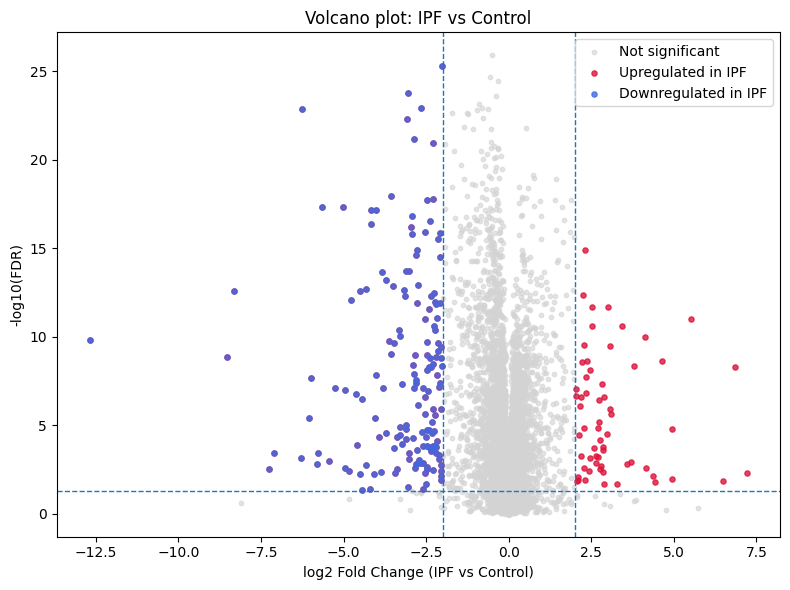

In [127]:
# volacno plot for NDC vs IPF 
# Create clean datafrmae 
import numpy as np

ctrl_ipf = ctrl_vs_ipf.copy()

# Remove any remaining NaNs (safety)
ctrl_ipf = ctrl_ipf.dropna(subset=['log2FoldChange', 'padj'])

# Add -log10 adjusted p-value
ctrl_ipf['-log10(padj)'] = -np.log10(ctrl_ipf['padj'])

# define significant thresholds 
logfc_thresh = 2
padj_thresh = 0.05

ctrl_ipf['Significant'] = (
    (ctrl_ipf['padj'] < padj_thresh) &
    (abs(ctrl_ipf['log2FoldChange']) > logfc_thresh)
)

# Create volacno plot

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Non-significant genes
plt.scatter(
    ctrl_ipf.loc[~ctrl_ipf['Significant'], 'log2FoldChange'],
    ctrl_ipf.loc[~ctrl_ipf['Significant'], '-log10(padj)'],
    color='lightgrey',
    alpha=0.6,
    s=10,
    label='Not significant'
)

# Upregulated genes (IPF > Control)
plt.scatter(
    ctrl_ipf.loc[ctrl_ipf_up, 'log2FoldChange'],
    ctrl_ipf.loc[ctrl_ipf_up, '-log10(padj)'],
    color='crimson',
    alpha=0.8,
    s=14,
    label='Upregulated in IPF'
)

# Downregulated genes (IPF < Control)
plt.scatter(
    ctrl_ipf.loc[ctrl_ipf_down, 'log2FoldChange'],
    ctrl_ipf.loc[ctrl_ipf_down, '-log10(padj)'],
    color='royalblue',
    alpha=0.8,
    s=14,
    label='Downregulated in IPF'
)

# Threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle='--', linewidth=1)
plt.axvline(logfc_thresh, linestyle='--', linewidth=1)
plt.axvline(-logfc_thresh, linestyle='--', linewidth=1)

plt.xlabel('log2 Fold Change (IPF vs Control)')
plt.ylabel('-log10(FDR)')
plt.title('Volcano plot: IPF vs Control')
plt.legend()

plt.tight_layout()
plt.show()

#plt.figure(figsize=(8, 6))

# Non-significant genes
#plt.scatter(
#    ctrl_ipf.loc[~ctrl_ipf['Significant'], 'log2FoldChange'],
#    ctrl_ipf.loc[~ctrl_ipf['Significant'], '-log10(padj)'],
#    color='lightgrey',
#    alpha=0.6,
#    s=10
#)

# Significant genes
#plt.scatter(
#    ctrl_ipf.loc[ctrl_ipf['Significant'], 'log2FoldChange'],
 #   ctrl_ipf.loc[ctrl_ipf['Significant'], '-log10(padj)'],
  #  color='crimson',
   # alpha=0.8,
    #s=12
#)

# Threshold lines
#plt.axhline(-np.log10(padj_thresh), linestyle='--', linewidth=1)
#plt.axvline(logfc_thresh, linestyle='--', linewidth=1)
#plt.axvline(-logfc_thresh, linestyle='--', linewidth=1)

#plt.xlabel('log2 Fold Change (IPF vs Control)')
#plt.ylabel('-log10(FDR)')
#plt.title('Volcano plot: IPF vs Control')

#plt.tight_layout()
#plt.show()


0.9780333333333333 ± 0.023961056366993132


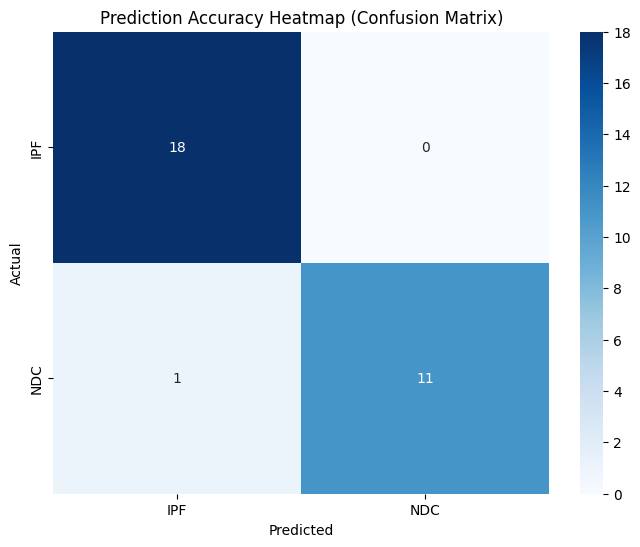

In [158]:
# 1st model prediction for ipf vs cntrl - 

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression 

from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

import matplotlib.pyplot as plt 


X = filtered_data_ipf_ctrl[["PKP1","OSR2","P2RX2", "LRRC10B", "LYPD5", "PARD6B", "LGI3", "FCHO1", "MMP7"]].values 

y = filtered_data_ipf_ctrl['Condition'].values 

 #Randomised the random_state (beneficial for a small dataset) and reports the average accuracy of the model, with standard deviation. 

n_seeds = 1000 

accuracies = [] 

for i in range(n_seeds): 

    X_train, X_test, y_train, y_test = train_test_split( 

        X, y, test_size=0.3, random_state=i, stratify=y 

    ) 

    model = KNeighborsClassifier(n_neighbors=3, weights='distance') 

    model.fit(X_train, y_train) 

    y_pred = model.predict(X_test) 

    accuracies.append(accuracy_score(y_test, y_pred)) 

accuracy=np.mean(accuracies) 

print(accuracy,'±',np.std(accuracies)) 

 

 

#Visualise model using confusion matrix 

cm = confusion_matrix(y_test, y_pred, labels=model.classes_) 

  

plt.figure(figsize=(8,6)) 

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 

            xticklabels=model.classes_, yticklabels=model.classes_) 

plt.title('Prediction Accuracy Heatmap (Confusion Matrix)') 

plt.xlabel('Predicted') 

plt.ylabel('Actual') 

plt.show() 

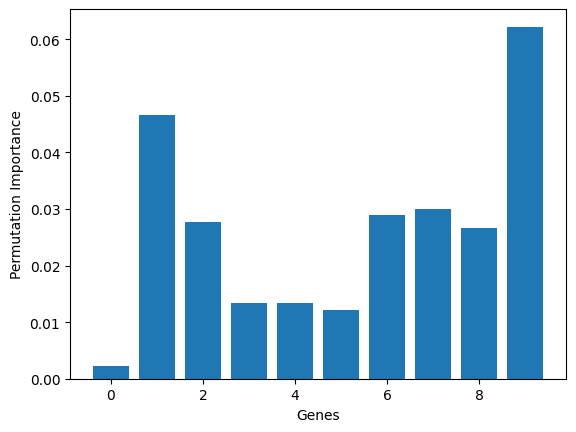

In [156]:

#Permutation importance to determine if features effect model performance
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=1, scoring='accuracy')
importances = result.importances_mean

plt.bar(range(len(importances)), importances)

plt.xlabel('Genes')
plt.ylabel('Permutation Importance')
plt.show()  

0.9606333333333335 ± 0.03145082581498368


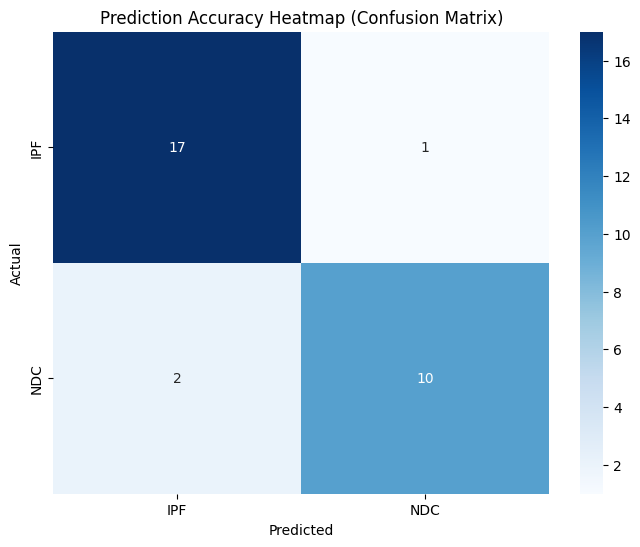

In [147]:
# 1st model prediction for ipf vs cntrl - 

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression 

from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

import matplotlib.pyplot as plt 


X = filtered_data_ipf_ctrl[["TCF21", "LPXN", "AQP3", "CTHRC1", "RUNX2"]].values 

y = filtered_data_ipf_ctrl['Condition'].values 

 #Randomised the random_state (beneficial for a small dataset) and reports the average accuracy of the model, with standard deviation. 

n_seeds = 1000 

accuracies = [] 

for i in range(n_seeds): 

    X_train, X_test, y_train, y_test = train_test_split( 

        X, y, test_size=0.3, random_state=i, stratify=y 

    ) 

    model1 = KNeighborsClassifier(n_neighbors=3, weights='distance') 

    model1.fit(X_train, y_train) 

    y_pred = model.predict(X_test) 

    accuracies.append(accuracy_score(y_test, y_pred)) 

accuracy=np.mean(accuracies) 

print(accuracy,'±',np.std(accuracies)) 

 

 

#Visualise model using confusion matrix 

cm = confusion_matrix(y_test, y_pred, labels=model.classes_) 

  

plt.figure(figsize=(8,6)) 

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 

            xticklabels=model.classes_, yticklabels=model.classes_) 

plt.title('Prediction Accuracy Heatmap (Confusion Matrix)') 

plt.xlabel('Predicted') 

plt.ylabel('Actual') 

plt.show() 

In [162]:

heatmap_data = X.apply(pd.to_numeric, errors="coerce")
heatmap_data = X.dropna(axis=0, how="all")
heatmap_data = X.dropna(axis=1, how="all")


# optional: select subset of genes
#heatmap_data = heatmap_data.iloc[:, :20]  # first 20 genes

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    cmap="PiYG",
    cbar=True
)

plt.xlabel("Genes")
plt.ylabel("Samples")
plt.title("RNA-seq Expression Heatmap")
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'apply'